<a href="https://colab.research.google.com/github/DCEG-workshops/statgen_workshop_tutorial/blob/main/src/07_multi_ancestry_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

Important: We want to mount the google drive for the data neeed for this workshop. Please open this [link](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1rui3w4tok2Z7EhtMbz6PobeC_fDxTw7G%3Fusp%3Dsharing) with your Google drive and find the "statgen_workshop" folder under "Share with me". Then add a shortcut to the folder under "My Drive".

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
input_dir="drive/MyDrive/statgen_workshop/data/workshop7/"
analysis_dir=os.getcwd() + "/07_analysis/"
os.environ['input_dir']=input_dir
os.environ['analysis_dir']=analysis_dir

Load R magic

In [ ]:
%load_ext rpy2.ipython

# PART 1. Multi-population Fine-mapping
## A single-hit region on chr 12

### mJAM

Step 1. Packages

Install dependencies for the hJAM R libary

In [ ]:
%%bash
apt-get install libgsl-dev libmpfr-dev

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl libgsl27 libgslcblas0
Suggested packages:
  gmp-doc libgmp10-doc gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html libmpfr-doc
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl libgsl-dev libgsl27 libgslcblas0 libmpfr-dev
0 upgraded, 6 newly installed, 0 to remove and 9 not upgraded.
Need to get 2,969 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgslcblas0 amd64 2.7.1+dfsg-3 [94.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl27 amd64 2.7.1+dfsg-3 [1,000 kB]
Get:5 

We need to install the hJAM and tidyverse R libaries. Here's the code to install them:


```
devtools::install_github("USCbiostats/hJAM")
if(!"tidyverse"%in%installed.packages()){install.packages('tidyverse')}
```

In the interest of time, we will add the pre-installed packages to R path so we don't have to wait for the R package installations.

In [ ]:
%%bash
cp /content/drive/MyDrive/statgen_workshop/tools/07_multi_ancestry_analysis_R_libs.tgz ./ && \
   tar -zxf 07_multi_ancestry_analysis_R_libs.tgz && ls usr/local/lib/R/site-library/

foreach
glmnet
gmp
hJAM
IRdisplay
IRkernel
irlba
iterators
matrixcalc
matrixStats
mixsqp
pbdZMQ
plyr
Rcpp
RcppArmadillo
RcppEigen
repr
reshape
reshape2
Rmpfr
shape
susieR


Add to R library Path

In [ ]:
%%R -i input_dir -i analysis_dir
.libPaths("usr/local/lib/R/site-library/")
.libPaths()

[1] "/usr/local/lib/R/site-library" "/usr/lib/R/site-library"      
[3] "/usr/lib/R/library"           


load R libraries

In [ ]:
%%R
library(hJAM) ## for mJAM_Forward, mJAM_SuSiE
library(tidyverse) ## for data cleaning and visualization
library(glue)


Error in library(hJAM) : there is no package called ‘hJAM’


Visualize marginal results

In [ ]:
%%R
meta_sumstat <- read.table(glue(input_dir, "MultiPopulation_FineMapping/12_109194870_110794870_meta_summary_stat.txt"), header = T)

  could not find function "glue"




Error in glue(input_dir, "MultiPopulation_FineMapping/12_109194870_110794870_meta_summary_stat.txt") : 
  could not find function "glue"


Meta P.value

In [ ]:
%%R
meta_sumstat %>%
  ggplot(aes(x = POS, y = -log10(as.numeric(P.value))))+
  geom_point(size = 1)+
  geom_hline(yintercept = -log10(5e-8), linetype="dashed", color = "red")+
  labs(x = "Position", y = "-log10(meta.p.value)",
       title = "Marginal signficance of meta-analyzed summary statistics")

  could not find function "%>%"




Error in meta_sumstat %>% ggplot(aes(x = POS, y = -log10(as.numeric(P.value)))) : 
  could not find function "%>%"


Population-specific P.value

In [ ]:
%%R
meta_sumstat %>%
  select(c(POS, EUR.P.value, AFR.P.value, HIS.P.value, EAS.P.value)) %>%
  mutate(EUR.P.value = as.numeric(EUR.P.value),
         AFR.P.value = as.numeric(AFR.P.value),
         HIS.P.value = as.numeric(HIS.P.value),
         EAS.P.value = as.numeric(EAS.P.value)) %>%
  pivot_longer(cols = EUR.P.value:EAS.P.value,
               names_to = "pop",
               values_to = "P.value") %>%
  ggplot(aes(x = POS, y = -log10(as.numeric(P.value))))+
  geom_point(size = 1)+
  geom_hline(yintercept = -log10(5e-8), linetype="dashed", color = "red")+
  facet_wrap(vars(pop), nrow = 2, scales = "free_y")+
  labs(x = "Position", y = "-log10(p.value)",
       title = "Marginal signficance by population")

  could not find function "%>%"




Error in meta_sumstat %>% select(c(POS, EUR.P.value, AFR.P.value, HIS.P.value,  : 
  could not find function "%>%"


Run various fine-mapping approaches

#### mJAM-Forward

In [ ]:
%%R
Marg_Result <- read.table(glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/Marg_results.txt"), header = T)
MAF_Result <- read.table(glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/MAF_results.txt"), header = T)
EUR_ONCO_dosage <- read.table(glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/EUR_ONCO_dosages.txt"), header = T, check.names = F)
AFR_ONCO_dosage <- read.table(glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/AFR_ONCO_dosages.txt"), header = T, check.names = F)
HIS_ONCO_dosage <- read.table(glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/HIS_ONCO_dosages.txt"), header = T, check.names = F)
EAS_ONCO_dosage <- read.table(glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/EAS_ONCO_dosages.txt"), header = T, check.names = F)

## sample size of discovery GWAS (as in summary statistics)
N_cases_EUR <- 122188; N_ctrl_EUR <- 604640
N_cases_AFR <- 19391; N_ctrl_AFR <- 61608
N_cases_HIS <- 3931; N_ctrl_HIS <- 26405
N_cases_EAS <- 10809; N_ctrl_EAS <- 95790
N_GWAS_EUR <- 4/(1/N_cases_EUR + 1/N_ctrl_EUR)
N_GWAS_AFR <- 4/(1/N_cases_AFR + 1/N_ctrl_AFR)
N_GWAS_HIS <- 4/(1/N_cases_HIS + 1/N_ctrl_HIS)
N_GWAS_EAS <- 4/(1/N_cases_EAS + 1/N_ctrl_EAS)

  could not find function "glue"




Error in glue(input_dir, "MultiPopulation_FineMapping/1_mJAM/data/Marg_results.txt") : 
  could not find function "glue"


fit mJAM with forward selection

In [ ]:
%%R
mJAM_Forward_fit <- hJAM::mJAM_Forward(N_GWAS = c(N_GWAS_EUR, N_GWAS_AFR, N_GWAS_HIS, N_GWAS_EAS),
                                       X_ref = list(EUR_ONCO_dosage, AFR_ONCO_dosage, HIS_ONCO_dosage, EAS_ONCO_dosage),
                                       Marg_Result = Marg_Result,
                                       EAF_Result = MAF_Result,
                                       condp_cut = 5e-08,
                                       within_pop_threshold = 0.20,
                                       across_pop_threshold = 0.10)


Error in loadNamespace(x) : there is no package called ‘hJAM’


index SNP's selected by mJAM_Forward

In [ ]:
%%R
mJAM_Forward_fit$index

  object 'mJAM_Forward_fit' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'mJAM_Forward_fit' not found


utility function for plotting

In [ ]:
%%R
plot_fine_mapping_res <- function(by.pop = FALSE,
                                  selected_index,
                                  cs_snp){

  if(by.pop){
    cs_snp_by_pop = cs_snp %>%
      select(c(index_SNP, CS_SNP, is_index, POS, EUR.P.value, AFR.P.value, HIS.P.value, EAS.P.value)) %>%
      mutate(EUR.P.value = as.numeric(EUR.P.value),
             AFR.P.value = as.numeric(AFR.P.value),
             HIS.P.value = as.numeric(HIS.P.value),
             EAS.P.value = as.numeric(EAS.P.value)) %>%
      pivot_longer(cols = EUR.P.value:EAS.P.value,
                   names_to = "pop",
                   values_to = "P.value")
    meta_sumstat %>%
      select(c(MarkerName, POS, EUR.P.value, AFR.P.value, HIS.P.value, EAS.P.value)) %>%
      mutate(EUR.P.value = as.numeric(EUR.P.value),
             AFR.P.value = as.numeric(AFR.P.value),
             HIS.P.value = as.numeric(HIS.P.value),
             EAS.P.value = as.numeric(EAS.P.value)) %>%
      pivot_longer(cols = EUR.P.value:EAS.P.value,
                   names_to = "pop",
                   values_to = "P.value") %>%
      ggplot(aes(x = POS, y = -log10(P.value)))+
      geom_point(color="grey", size  = 1.5)+
      geom_point(aes(color = index_SNP, group = index_SNP), data = cs_snp_by_pop, size  = 1)+
      geom_point(data = filter(cs_snp_by_pop, is_index == T),
                 colour="red", shape=1, size=1.5, stroke=1)+
      geom_hline(yintercept = -log10(5e-8), linetype="dashed", color = "red")+
      facet_wrap(vars(pop), nrow = 2, scales = "free_y")+
      labs(x = "Position", y = "-log10(p.value)",
           title = "Index SNPs and credible sets (by population)")
  }else{
    meta_sumstat %>%
      ggplot(aes(x = POS, y = -log10(as.numeric(P.value))))+
      geom_point(color="grey", size  = 1.5)+
      geom_point(aes(color = index_SNP, group = index_SNP), data = cs_snp, size  = 1)+
      geom_point(data = filter(cs_snp, is_index == T),
                 colour="red", shape=1, size=1.5, stroke=1)+
      geom_hline(yintercept = -log10(5e-8), linetype="dashed", color = "red")+
      labs(x = "Position", y = "-log10(p.value)",
           title = "Index SNPs and credible sets")
  }

}

pull variants in mJAM-Forward credible sets

In [ ]:
%%R
selected_index_forward <- mJAM_Forward_fit$index$SNP
cs_snp_forward <- mJAM_Forward_fit$cs %>%
  filter(CS_in == TRUE) %>%
  left_join(meta_sumstat, by = c("CS_SNP"="MarkerName")) %>%
  mutate(is_index = (index_SNP == CS_SNP)) %>%
  left_join(tibble(index_SNP = selected_index_forward,
                   oldname = meta_sumstat$MarkerName_old[match(selected_index_forward,meta_sumstat$MarkerName)],
                   order = 1:length(selected_index_forward)), by = "index_SNP") %>%
  mutate(index_SNP_legend = paste0("(#",order,")",oldname)) %>%
  select(-index_SNP) %>%
  rename(index_SNP = index_SNP_legend)

  object 'mJAM_Forward_fit' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'mJAM_Forward_fit' not found


 mJAM-Forward index SNPs and credible sets (meta P values)

In [ ]:
%%R
plot_fine_mapping_res(by.pop = FALSE,
                      selected_index = selected_index_forward,
                      cs_snp = cs_snp_forward)

  could not find function "%>%"




Error in meta_sumstat %>% ggplot(aes(x = POS, y = -log10(as.numeric(P.value)))) : 
  could not find function "%>%"


mJAM-Forward index SNPs and credible sets (population-specific P values)

In [ ]:
%%R
plot_fine_mapping_res(by.pop = TRUE,
                      selected_index = selected_index_forward,
                      cs_snp = cs_snp_forward)

  could not find function "%>%"




Error in cs_snp %>% select(c(index_SNP, CS_SNP, is_index, POS, EUR.P.value,  : 
  could not find function "%>%"


#### mJAM-SuSiE  

fit mJAM with Sum of Single Effect (Bayesian feature selection)

In [ ]:
%%R
mJAM_SuSiE_fit <- hJAM::mJAM_SuSiE(Marg_Result = Marg_Result,
                                   EAF_Result = MAF_Result,
                                   N_GWAS = c(N_GWAS_EUR, N_GWAS_AFR, N_GWAS_HIS, N_GWAS_EAS),
                                   X_ref = list(EUR_ONCO_dosage, AFR_ONCO_dosage, HIS_ONCO_dosage, EAS_ONCO_dosage))


mJAM_SuSiE_CS_0.95_Output <- hJAM::mJAM_SuSiE_get_cs(mJAM_SuSiE_fit,0.95)


Error in loadNamespace(x) : there is no package called ‘hJAM’


pull mJAM-SuSiE index SNPs and credible sets

In [ ]:
%%R
selected_index_susie <- mJAM_SuSiE_CS_0.95_Output$index_SNP
cs_snp_susie <- mJAM_SuSiE_CS_0.95_Output %>%
  left_join(meta_sumstat, by = c("CS_SNP"="MarkerName")) %>%
  mutate(is_index = (index_SNP == CS_SNP))

  object 'mJAM_SuSiE_CS_0.95_Output' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'mJAM_SuSiE_CS_0.95_Output' not found


mJAM-SuSiE index SNPs and credible sets (meta P values)

In [ ]:
%%R
plot_fine_mapping_res(by.pop = FALSE,
                      selected_index = selected_index_susie,
                      cs_snp = cs_snp_susie)

  could not find function "%>%"




Error in meta_sumstat %>% ggplot(aes(x = POS, y = -log10(as.numeric(P.value)))) : 
  could not find function "%>%"


 mJAM-SuSiE index SNPs and credible sets (population-specific P values)

In [ ]:
%%R
plot_fine_mapping_res(by.pop = TRUE,
                      selected_index = selected_index_susie,
                      cs_snp = cs_snp_susie)

  could not find function "%>%"




Error in cs_snp %>% select(c(index_SNP, CS_SNP, is_index, POS, EUR.P.value,  : 
  could not find function "%>%"


## COJO

Step 1: installation: https://yanglab.westlake.edu.cn/software/gcta/#Download

In [ ]:
%%bash
wget https://yanglab.westlake.edu.cn/software/gcta/bin/gcta-1.94.1-linux-kernel-3-x86_64.zip && unzip gcta-1.94.1-linux-kernel-3-x86_64.zip

Archive:  gcta-1.94.1-linux-kernel-3-x86_64.zip
   creating: gcta-1.94.1-linux-kernel-3-x86_64/
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/MIT_License.txt  
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/README.txt  
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/test.bed  
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/test.bim  
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/test.fam  
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/test.phen  
  inflating: gcta-1.94.1-linux-kernel-3-x86_64/gcta-1.94.1  


--2023-11-21 18:41:54--  https://yanglab.westlake.edu.cn/software/gcta/bin/gcta-1.94.1-linux-kernel-3-x86_64.zip
Resolving yanglab.westlake.edu.cn (yanglab.westlake.edu.cn)... 42.247.30.189, 124.160.108.195, 2001:250:6413:1002:250:56ff:fe90:f4c7
Connecting to yanglab.westlake.edu.cn (yanglab.westlake.edu.cn)|42.247.30.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14337891 (14M) [application/zip]
Saving to: ‘gcta-1.94.1-linux-kernel-3-x86_64.zip’

     0K .......... .......... .......... .......... ..........  0%  250K 56s
    50K .......... .......... .......... .......... ..........  0%  252K 55s
   100K .......... .......... .......... .......... ..........  1%  253K 55s
   150K .......... .......... .......... .......... ..........  1% 55.6M 41s
   200K .......... .......... .......... .......... ..........  1% 32.4M 33s
   250K .......... .......... .......... .......... ..........  2% 62.8M 27s
   300K .......... .......... .......... .......... ...

In [ ]:
ls gcta-1.94.1-linux-kernel-3-x86_64/

gcta-1.94.1*  MIT_License.txt  README.txt  test.bed  test.bim  test.fam  test.phen


Step 2: Running COJO using command line

In [ ]:
%%bash
mkdir -p ${analysis_dir}/2_COJO/results/

./gcta-1.94.1-linux-kernel-3-x86_64/gcta-1.94.1 \
--bfile ${input_dir}/MultiPopulation_FineMapping/2_COJO/data/12_109194870_110794870 \
--cojo-file ${input_dir}/MultiPopulation_FineMapping/2_COJO/data/12_109194870_110794870.ma \
--cojo-slct --cojo-p 5e-08 \
--out ${analysis_dir}/2_COJO/results/AllPopRes

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 18:41:59 UTC on Tue Nov 21 2023.
Hostname: e59b2aff7916

Accepted options:
--bfile drive/MyDrive/statgen_workshop/data/workshop7//MultiPopulation_FineMapping/2_COJO/data/12_109194870_110794870
--cojo-file drive/MyDrive/statgen_workshop/data/workshop7//MultiPopulation_FineMapping/2_COJO/data/12_109194870_110794870.ma
--cojo-slct
--cojo-p 5e-08
--out /content/07_analysis//2_COJO/results/AllPopRes


Reading PLINK FAM file from [drive/MyDrive/statgen_workshop/data/workshop7//MultiPopulation_FineMapping/2_COJO/data/12_109194870_110794870.fam].
10000 individuals to be included from [drive/MyDrive/statgen_workshop/data/

Read the results in R

In [ ]:
%%R
COJO_res <- read.table(glue(analysis_dir, "2_COJO/results/AllPopRes", ".jma.cojo"),
                       header = T, sep = '\t')

  could not find function "glue"




Error in glue(analysis_dir, "2_COJO/results/AllPopRes", ".jma.cojo") : 
  could not find function "glue"


note that COJO only provides index SNP selection

In [ ]:
%%R
COJO_res

  object 'COJO_res' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'COJO_res' not found


 plot COJO index SNPs

In [ ]:
%%R
meta_sumstat %>%
  ggplot(aes(x = POS, y = -log10(as.numeric(P.value))))+
  geom_point(color = "grey")+
  geom_point(data = meta_sumstat[meta_sumstat$MarkerName %in% COJO_res$SNP,],
             color = 'black')+
  geom_point(data = meta_sumstat[meta_sumstat$MarkerName %in% COJO_res$SNP,],
             colour="red", shape=1, size=2.5, stroke=1.5)+
  geom_text(
    data = meta_sumstat[match(COJO_res$SNP, meta_sumstat$MarkerName),],
    label= COJO_res$SNP,
    nudge_x = 0.25, nudge_y = 0.3, check_overlap = T, size = 2.5
  )+
  labs(x = "Position", y = "-log10(P.value)",
       title = "COJO index SNPs")

  could not find function "%>%"




Error in meta_sumstat %>% ggplot(aes(x = POS, y = -log10(as.numeric(P.value)))) : 
  could not find function "%>%"


## MsCAVIAR

Step1: installation: https://github.com/nlapier2/MsCAVIAR

In [ ]:
%%bash
git clone https://github.com/nlapier2/MsCAVIAR.git && cd MsCAVIAR/ && make

g++ -std=c++11 -fopenmp MsCaviar.cpp MsPostCal.cpp MsUtil.cpp   -I /content/MsCAVIAR/armadillo/include/ -DARMA_DONT_USE_WRAPPER -llapack -lblas -lgslcblas  -lgsl -o MsCAVIAR


Cloning into 'MsCAVIAR'...


Step 2: prepare files for MsCAVIAR

In [ ]:
%%R
msCAVIAR_Dir = glue(input_dir, "/MultiPopulation_FineMapping/3_msCAVIAR/data/")
msCAVIAR_output_Dir = glue(analysis_dir, "3_msCAVIAR/results/")
dir.create(msCAVIAR_output_Dir, recursive=TRUE)

  could not find function "glue"




Error in glue(input_dir, "/MultiPopulation_FineMapping/3_msCAVIAR/data/") : 
  could not find function "glue"


LD and zscores for each population

In [ ]:
%%R
all.files = list.files(path = msCAVIAR_Dir)
ld.files = all.files[ endsWith(all.files, paste0("_LD.txt")) ]
write.table(paste0(msCAVIAR_Dir, ld.files), paste0(msCAVIAR_Dir, "ld.files.txt"), quote = F, col.names = F, row.names = F)
zscore.files = all.files[ endsWith(all.files, paste0("_zscore.txt")) ]
write.table(paste0(msCAVIAR_Dir, zscore.files), paste0(msCAVIAR_Dir, "zscore.files.txt"), quote = F,  col.names = F, row.names = F)

N_Sample = c(N_GWAS_EUR, N_GWAS_AFR, N_GWAS_HIS, N_GWAS_EAS)

  object 'msCAVIAR_Dir' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'msCAVIAR_Dir' not found


Step 3: run MsCAVIAR using command line tool or in R

In [ ]:
%%R
system(paste0("/content/MsCAVIAR//MsCAVIAR -l ",
              paste0( msCAVIAR_Dir, "ld.files.txt"),
              " -z ", paste0( msCAVIAR_Dir, "zscore.files.txt"),
              " -n ", paste(round(N_Sample), collapse = ","),
              " -o ", paste0(msCAVIAR_output_Dir, "output_12_109194870_110794870"),
              " -c ", 1), intern = T) ## allow max causal = 1

  object 'msCAVIAR_Dir' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'msCAVIAR_Dir' not found


Step 4: read MsCAVIAR results

In [ ]:
%%R
mscaviar_cs_snps = read.table(paste0(msCAVIAR_output_Dir, "output_12_109194870_110794870_set.txt"), sep = "\t", header=F)
mscaviar_pip = read.table(paste0(msCAVIAR_output_Dir, "output_12_109194870_110794870_post.txt"), sep = "\t", header=T)
mscaviar_index = mscaviar_pip %>%
  left_join(meta_sumstat[,c("MarkerName", "MarkerName_old")], by = c("SNP_ID" = "MarkerName")) %>%
  arrange(desc(Prob_in_pCausalSet)) %>% head(1) %>% pull(MarkerName_old)

  object 'msCAVIAR_output_Dir' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'msCAVIAR_output_Dir' not found


 Step 5: plot MsCAVIAR results

In [ ]:
%%R
meta_sumstat %>%
  ggplot(aes(x = POS, y = -log10(as.numeric(P.value))))+
  geom_point(color = "grey")+
  geom_point(data = filter(meta_sumstat, MarkerName %in% mscaviar_cs_snps$V1) ,
             color = "blue")+
  geom_point(data = filter(meta_sumstat,  MarkerName_old %in% mscaviar_index),
             colour="red", shape=1, size=2.5, stroke=1.5)+
  geom_label(
    data = filter(meta_sumstat,  MarkerName_old %in% mscaviar_index),
    label= mscaviar_index,
    nudge_x = 0.25, nudge_y = 0.9, size = 4
  )+
  geom_hline(yintercept = -log10(5e-8), linetype="dashed", color = "red")+
  labs(x = "Position", y = "-log10(meta P.value)", title = "MsCAVIAR index SNPs and credible sets")

  could not find function "%>%"




Error in meta_sumstat %>% ggplot(aes(x = POS, y = -log10(as.numeric(P.value)))) : 
  could not find function "%>%"


# Genomewide PRS

## Multi-population GW PRS with PRS-CSx

Step1: PRS-CSx installation https://github.com/getian107/PRScsx

Please note that the h5py and scipy libraries might be needed in your own runtime (they are pre-installed in the colab runtime).

In [ ]:
%%bash
git clone https://github.com/getian107/PRScsx.git


Cloning into 'PRScsx'...


Step2: take a look at population-specific PCa summary statistics on chr22

In [ ]:
%%R -i input_dir -i analysis_dir
library(glue)
library(tidyverse)
sumstat_EUR <- read.table(glue(input_dir, "Genomewide_PRS/data/summaryStats_hm3_chr22.EUR.txt"), header = T)
head(sumstat_EUR)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
         SNP A1 A2    BETA      P
1  rs2027653  T  C -0.0087 0.3773
2  rs9605927  T  C  0.0124 0.5208
3 rs16984366  T  C -0.0006 0.9376
4  rs4390844  T  C  0.0016 0.8468
5  rs2072466  T  C  0.0010 0.8936
6   rs175138  A  G -0.0120 0.0325


Step3: Run PRS-CSx script using command line - this step takes more than an hour to run on the free version of colab. So we provide the commented out code here but will be using pre-run results for the rest of the tutorial

In [ ]:
%%bash
# mkdir -p ${analysis_dir}/Genomewide_PRS/results/

# python /content/PRScsx/PRScsx.py \
#  --ref_dir=${input_dir}/Genomewide_PRS/ldRefPanel/ \
#  --bim_prefix=${input_dir}/Genomewide_PRS/data/H3.hm3.chr22.rsid \
#  --sst_file=${input_dir}/Genomewide_PRS/data/summaryStats_hm3_chr22.AFR.txt,${input_dir}/Genomewide_PRS/data/summaryStats_hm3_chr22.EUR.txt,${input_dir}/Genomewide_PRS/data/summaryStats_hm3_chr22.EAS.txt,${input_dir}/Genomewide_PRS/data/summaryStats_hm3_chr22.HIS.txt \
#  --n_gwas=58995,406587,38851,13686 \
#  --pop=AFR,EUR,EAS,AMR \
#  --meta=TRUE \
#  --chrom=22 \
#  --out_dir=${analysis_dir}/Genomewide_PRS/results/ \
#  --out_name=test_chr22

Step4: read results
Note that we are reading in the pre-generated results here, please change the file path if you have run the PRS-CSx script

In [ ]:
%%R
prscsx_res <- read.table(glue(input_dir, "Genomewide_PRS/results/test_chr22_META_pst_eff_a1_b0.5_phiauto_chr22.txt"), header = F)
colnames(prscsx_res) <- c("chr", "rsid", "pos", "effect.allele", "other.allele", "prscsx_weight")
head(prscsx_res)

  chr      rsid      pos effect.allele other.allele prscsx_weight
1  22 rs2186521 16498387             T            C  1.518902e-05
2  22 rs4911642 16504399             T            C -1.348063e-05
3  22 rs7287144 16886873             G            A  2.609310e-05
4  22 rs5748662 16892858             A            G  9.982220e-06
5  22 rs2027653 16918335             C            T  2.063079e-05
6  22 rs2379965 17023514             C            T -3.126292e-06


Step5: visualize weights before vs after PRS-CSx

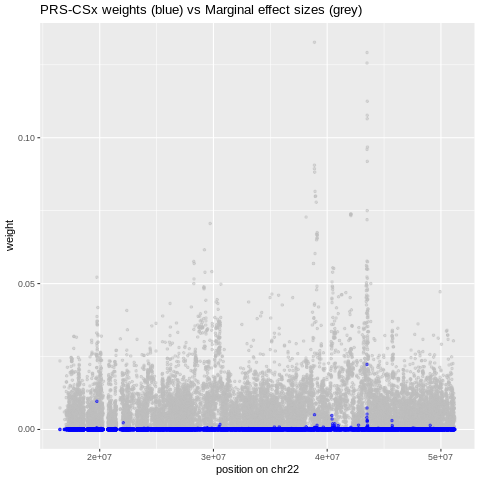

In [ ]:
%%R
meta_sumstat_chr22 <- read.table(glue(input_dir,"Genomewide_PRS/data/meta_summaryStats_hm3_chr22.txt"), header = T)

meta_sumstat_chr22 %>%
  left_join(prscsx_res, by = c("chr","pos","rsid")) %>%
  mutate(flip_prscsx_weight = (Allele1 == other.allele),
         prscsx_weight_flipped = ifelse(flip_prscsx_weight, (-1)*prscsx_weight, prscsx_weight)) %>%
  ggplot(aes(x = pos))+
  geom_point(aes(y = abs(Effect)), alpha = 0.5, size=1, color = "grey")+
  geom_point(aes(y = abs(prscsx_weight_flipped)), alpha = 0.5, size=1, color = "blue")+
  labs(title = "PRS-CSx weights (blue) vs Marginal effect sizes (grey)",
       y = "weight", x = "position on chr22")

# PRS Evaluation

 ### Import Libraries

Install pROC

In [ ]:
%%R
install.packages("pROC")

(as ‘lib’ is unspecified)



















	‘/tmp/Rtmpuq21h4/downloaded_packages’



In [ ]:
%%R -i analysis_dir -i input_dir
library(dplyr)
library(ggplot2)
library(tidyr)
library(purrr) # purrr function
library(pROC) # roc for glm models
library(stringr)


Attaching package: ‘pROC’



    cov, smooth, var




### Define Global Vars

In [ ]:
%%R
data.loc = glue(input_dir, "PRS_Evaluation/")
data.loc

drive/MyDrive/statgen_workshop/data/workshop7/PRS_Evaluation/
FALSE


### Define Functions

In [ ]:
%%R

# pull the weights needed for the PRS calculation for each variant from meta-data (pull info for dosage)
row_pull = function(in.chr, in.pos, in.ref, in.alt, wt.df.name){
  wt.df = get(wt.df.name)

    wt.df[wt.df$chr == in.chr & wt.df$pos == in.pos &
            ((wt.df$effect_allele == in.ref & wt.df$other_allele == in.alt) |
               (wt.df$other_allele == in.ref & wt.df$effect_allele == in.alt)), ]
}

# flip dosages in dosage file to reflect added risk
correct_dosage = function(in.dosage){
  chrpos.tmp = cur_column()
  # compare risk allele against alt and flip if mismatch (check what alt refers to: )
  if (meta.data.wts[meta.data.wts$chr_pos_alt_ref == chrpos.tmp, "wt_flip"][[1]] == 1){
    abs(in.dosage-2)
  } else {
    in.dosage
  }
}

### Import Data

In [ ]:
%%R

dta.pc.dosage =
  glue(data.loc, "dta_PC_PRS_dosage.rds") %>%
  readRDS()

dta.meta.data =
  glue(data.loc, "dta.PC.MetaData.rds") %>%
  readRDS()

# remove effect_weight_new
PRS.weights.data =
  glue(data.loc, "PRS.weights.rds") %>%
  readRDS()

look at all the data to get an idea of what it is

In [ ]:
%%R
dta.pc.dosage[1:10,1:30] %>% as.data.frame()

   id          V1           V2           V3           V4           V5
1   1 0.006239795  0.000115783  0.000814226 -0.000050300 -0.000803027
2   2 0.002319277 -0.002333773  0.002061308 -0.000357685 -0.001327950
3   3 0.008843116  0.001849257 -0.000303652  0.000036600 -0.000589372
4   4 0.004513058 -0.000167595 -0.000188342 -0.000810472 -0.001020396
5   5 0.008061663  0.001621103 -0.000071100 -0.000290521 -0.000286320
6   6 0.006965986  0.000709415 -0.000004210  0.000443168 -0.001213145
7   7 0.006276979  0.000295608  0.001270645  0.000065200  0.000071700
8   8 0.007979909  0.001358208 -0.000018100  0.000329236  0.000277050
9   9 0.008983604  0.002123540 -0.000375604  0.000471425 -0.000864223
10 10 0.007819441  0.001783264 -0.000693010  0.000893417 -0.000256052
             V6           V7           V8           V9          V10
1   0.000726694  0.001693085 -0.001162986 -0.006698213  0.003435046
2   0.001823430  0.001023044 -0.002268107  0.002485728  0.000706895
3   0.001309735  0.0021000

In [ ]:
%%R
dta.pc.dosage %>% group_by(eth, cancer) %>% tally()

# A tibble: 10 × 3
# Groups:   eth [5]
   eth          cancer     n
   <chr>         <dbl> <int>
 1 Afr-Amr           0   200
 2 Afr-Amr           1   200
 3 Hawaiian          0   200
 4 Hawaiian          1   200
 5 Japanese-Amr      0   200
 6 Japanese-Amr      1   200
 7 Latino            0   200
 8 Latino            1   200
 9 White             0   200
10 White             1   200


In [ ]:
%%R
dta.meta.data %>% head() %>% as.data.frame()

  CHR      POS REF ALT  chr_pos_alt_ref
1   1  7917076   G   A    1:7917076:G:A
2   1 10566215   A   G   1:10566215:A:G
3   1 10566272   C   T   1:10566272:C:T
4   1 16185635   G GTT 1:16185635:G:GTT
5   1 18807339   T   C   1:18807339:T:C
6   1 22503282   G   C   1:22503282:G:C


In [ ]:
%%R
PRS.weights.data %>% head %>% as.data.frame()

  chr      pos effect_allele other_allele effect_weight effect_weight_new
1   1 10566272             C            T        0.0390            0.4818
2   1 16185635           GTT            G        0.0353            0.4360
3   1 24716207             A            G        0.0309            0.3817
4   1 27679797             A            G        0.0286            0.3533
5   1 31381106             G            C        0.0340            0.4200
6   1 46425500             G            A        0.0458            0.5658
     chr_pos
1 1:10566272
2 1:16185635
3 1:24716207
4 1:27679797
5 1:31381106
6 1:46425500


### Prep Data

1) append the weights information (from literature) to our meta-data file

In [ ]:
%%R
meta.data.wts =
  dta.meta.data %>%
  # use our function to create a new column with weights from the weights file
  # this is basically merging based on chromosome, position, allele 1, and allele 2, it is a
  # custom function to handle multialleleic cases
  mutate(prs_info = pmap(.f=row_pull, list(CHR, POS, REF, ALT, "PRS.weights.data")),
         prs_info_n = prs_info %>% map_int(.f=function(x){nrow(x)})) %>%
  unnest_wider(prs_info, names_sep="_") %>%
  # filter out variants from our meta-data that we are not interested in
  filter(prs_info_n == 1) %>%

  # identify what variants need to have their dosage transformed to reflect added risk
  # for PRS calculation
  mutate(wt_flip = ifelse(prs_info_effect_allele != ALT, 1, 0))

meta.data.wts %>% head %>% as.data.frame()

  CHR      POS REF ALT  chr_pos_alt_ref prs_info_chr prs_info_pos
1   1 10566272   C   T   1:10566272:C:T            1     10566272
2   1 16185635   G GTT 1:16185635:G:GTT            1     16185635
3   1 24716207   G   A   1:24716207:G:A            1     24716207
4   1 27679797   A   G   1:27679797:A:G            1     27679797
5   1 31381106   G   C   1:31381106:G:C            1     31381106
6   1 46425500   G   A   1:46425500:G:A            1     46425500
  prs_info_effect_allele prs_info_other_allele prs_info_effect_weight
1                      C                     T                 0.0390
2                    GTT                     G                 0.0353
3                      A                     G                 0.0309
4                      A                     G                 0.0286
5                      G                     C                 0.0340
6                      G                     A                 0.0458
  prs_info_effect_weight_new prs_info_chr_pos pr

2) use our wt_flip variable to recode the dosages as "risk" based on meta-data file

In [ ]:
%%R
dta.pc.dosage.risk =
  dta.pc.dosage %>%
  # select all covariates from individual-level dosage file, then select all
  # variants in our meta data file (variants to be used in the PRS calculation)
  select(-contains(":"), meta.data.wts$chr_pos_alt_ref) %>%
  # mutate across all dosages (chrpos), pass to flip function that returns transformed dosage vector
  mutate(across(contains(":"), correct_dosage))

### PRS Calculation

calculate unweighted PRS

create a new variable prs_uwt which is just a sum of all PRS risk alleles, across all variants

In [ ]:
%%R
dta.pc.dosage.risk$prs_uwt =
  dta.pc.dosage.risk %>%
  select(meta.data.wts$chr_pos_alt_ref) %>%
  as.matrix() %>%
  apply(., 1, sum)

calculate weighted PRS

Sum all risk alleles, after applying weights to each variant, done using matrix multiplication

In [ ]:
%%R
dta.pc.dosage.risk$prs_wtd =
  c(as.matrix(select(dta.pc.dosage.risk, meta.data.wts$chr_pos_alt_ref)) %*% meta.data.wts$prs_info_effect_weight)

### Descriptives of PRS

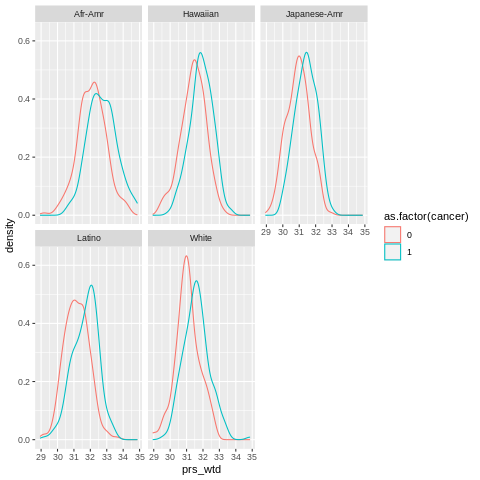

In [ ]:
%%R
dta.pc.dosage.risk %>%
  ggplot(aes(x=prs_wtd, color=as.factor(cancer)))+
  geom_density() +
  facet_wrap(~eth)

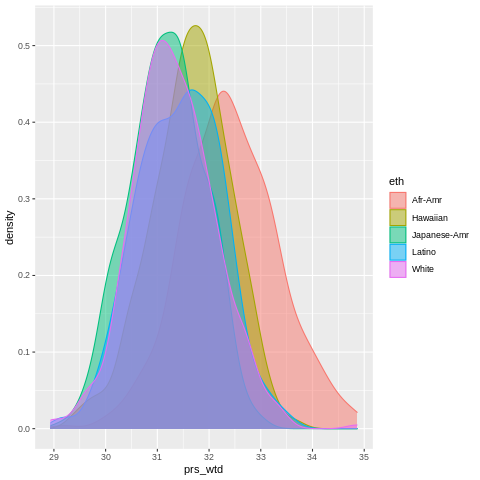

In [ ]:
%%R
dta.pc.dosage.risk %>%
  ggplot(aes(x=prs_wtd, fill=eth, color=eth))+
  geom_density(alpha=.5)

## Apply Standardization Techniques

## Ancestry-Residual Model for removal of "relatedness/ancestry" variation in PRS

In [ ]:
%%R
dta.pc.dosage.risk$mdl.resid =
  lm(data=dta.pc.dosage.risk,
     formula = as.formula("prs_wtd ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10"))$residuals

standardize new 'residualized PRS"

In [ ]:
%%R
prs_resid_stats =
  dta.pc.dosage.risk %>%
  # select controls
  filter(cancer == 0) %>%
  summarise(mean_prs_resid = mean(mdl.resid), sd_prs_resid = sd(mdl.resid))

In [ ]:
%%R
dta.pc.dosage.risk$prs_mdl_resid_std =
  (dta.pc.dosage.risk$mdl.resid - prs_resid_stats$mean_prs_resid)/prs_resid_stats$sd_prs_resid

Standardized within Race/Eth

In [ ]:
%%R
prs_eth_stats_eth =
  dta.pc.dosage.risk %>%
  # select controls
  filter(cancer == 0) %>%
  group_by(eth) %>%
  summarise(mean_prs_wts_eth = mean(prs_wtd), sd_prs_wtd_eth = sd(prs_wtd))

In [ ]:
%%R
prs_eth_stats_combined =
  dta.pc.dosage.risk %>%
  # select controls
  filter(cancer == 0) %>%
  summarise(mean_prs_wts_combined = mean(prs_wtd), sd_prs_wtd_combined = sd(prs_wtd))

In [ ]:
%%R
dta.pc.dosage.risk =
  dta.pc.dosage.risk %>%
  left_join(prs_eth_stats_eth) %>%
  mutate(prs_wtd_eth_std = (prs_wtd - mean_prs_wts_eth)/sd_prs_wtd_eth,
         prs_wtd_std = (prs_wtd - prs_eth_stats_combined$mean_prs_wts_combined)/
           prs_eth_stats_combined$sd_prs_wtd_combined)

Joining with `by = join_by(eth)`


## Compare All Types of PRS we estimated

compare prs distributions across race/eth, combined, among controls

In [ ]:
%%R
prs.compare.plt.data =
  rbind(dta.pc.dosage.risk %>% select(prs_wtd_std, prs_wtd_eth_std, prs_mdl_resid_std) %>%
          mutate(eth = "Combined"),
        dta.pc.dosage.risk %>% select(prs_wtd_std, prs_wtd_eth_std, prs_mdl_resid_std, eth)) %>%
  pivot_longer(starts_with("prs"), values_to = "PRS_Value", names_to = "PRS_type")

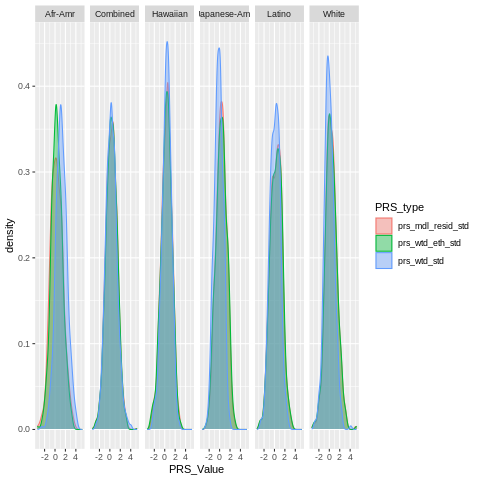

In [ ]:
%%R
prs.compare.plt.data %>%
  ggplot(aes(x=PRS_Value, color=PRS_type, fill=PRS_type))+
  geom_density(alpha=.4) +
  facet_wrap(~eth, nrow = 1)

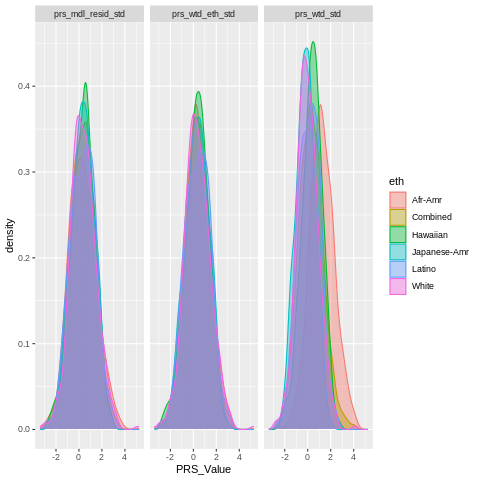

In [ ]:
%%R
prs.compare.plt.data %>%
  ggplot(aes(x=PRS_Value, color=eth, fill=eth))+
  geom_density(alpha=.4) +
  facet_wrap(~PRS_type, nrow = 1)

## Regression Analysis

Simple PRS model with age and PC adjustment

In [ ]:
%%R
# define formula
fm = as.formula("cancer ~ prs_wtd_std + age_draw + V1 + V2 + V3 + V4 + V5 + V6")

# fit model
res = glm(fm, data = dta.pc.dosage.risk, binomial(link='logit'))
res


Call:  glm(formula = fm, family = binomial(link = "logit"), data = dta.pc.dosage.risk)

Coefficients:
(Intercept)  prs_wtd_std     age_draw           V1           V2           V3  
   -2.91138      0.82011      0.03824   -106.47091     -9.83845      9.81196  
         V4           V5           V6  
  -12.55340     14.27787    -25.23468  

Degrees of Freedom: 1999 Total (i.e. Null);  1991 Residual
Null Deviance:	    2773 
Residual Deviance: 2498 	AIC: 2516


view coefficient results as data.frame

In [ ]:
%%R
res %>% summary() %>% pluck("coefficients") %>% as.data.frame()

                 Estimate   Std. Error    z value     Pr(>|z|)
(Intercept)   -2.91138143  0.429518352 -6.7782469 1.216429e-11
prs_wtd_std    0.82011209  0.058606795 13.9934641 1.708815e-44
age_draw       0.03824214  0.006154995  6.2131875 5.192044e-10
V1          -106.47091124 14.891030226 -7.1500030 8.677598e-13
V2            -9.83845204 11.273713167 -0.8726896 3.828323e-01
V3             9.81196500 12.563632438  0.7809815 4.348134e-01
V4           -12.55339986  6.929674816 -1.8115424 7.005693e-02
V5            14.27786875 11.751996866  1.2149313 2.243923e-01
V6           -25.23468450 12.364910638 -2.0408303 4.126770e-02


check aic

In [ ]:
%%R
res$aic

[1] 2516.303


check AUC


Call:
roc.formula(formula = dta.pc.dosage.risk$cancer ~ res_pred_prob,     plot = TRUE, print.auc = TRUE)

Data: res_pred_prob in 1000 controls (dta.pc.dosage.risk$cancer 0) < 1000 cases (dta.pc.dosage.risk$cancer 1).
Area under the curve: 0.7075


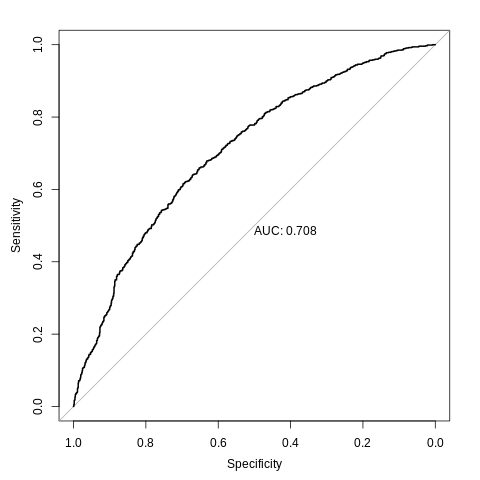

In [ ]:
%%R
res_pred_prob = predict(res, newdata = dta.pc.dosage.risk, type = "response")
roc(dta.pc.dosage.risk$cancer ~ res_pred_prob, plot = TRUE, print.auc = TRUE)

AUC is 0.7075, lets compare against a model with the covariates (which may be the ones actually producing a high auc)

fit model


Call:
roc.formula(formula = dta.pc.dosage.risk$cancer ~ res_pred_prob_null_mdl,     plot = TRUE, print.auc = TRUE)

Data: res_pred_prob_null_mdl in 1000 controls (dta.pc.dosage.risk$cancer 0) < 1000 cases (dta.pc.dosage.risk$cancer 1).
Area under the curve: 0.5832


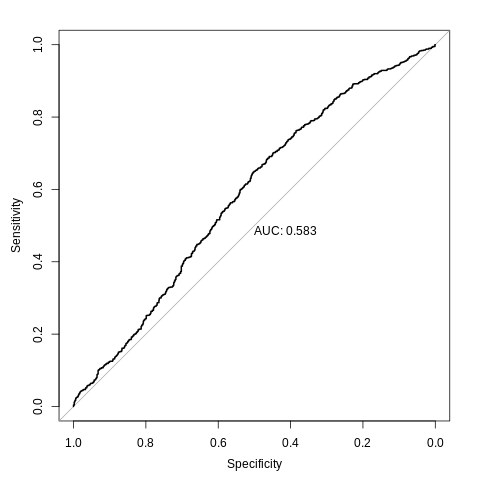

In [ ]:
%%R
null.mdl.res = glm(as.formula("cancer ~ age_draw + V1 + V2 + V3 + V4 + V5 + V6"),
                   data = dta.pc.dosage.risk, binomial(link='logit'))

res_pred_prob_null_mdl = predict(null.mdl.res, newdata = dta.pc.dosage.risk, type = "response")
roc(dta.pc.dosage.risk$cancer ~ res_pred_prob_null_mdl, plot = TRUE, print.auc = TRUE)

the null model produces an AUC of 0.5832, versus including PRS which is .71, this is a considerable increase due to PRS.

## Compare a variety of models

prs terms to evaluate: prs_wtd_std, prs_wtd_eth_std, prs_mdl_resid_std

function to run regression and pull PRS term and other fit stats

In [ ]:
%%R
fit_prs_models = function(in.model, in.eth, in.df.name){
  dta.tmp = get(in.df.name)

  # filter data
  if (in.eth != "Combined"){
    dta.tmp =
      dta.tmp %>%
      filter(eth == in.eth)
  }

  # fit model:
  res = glm(as.formula(in.model), data = dta.tmp, binomial(link='logit'))

  # extract prs terms
  res.df =
    res %>% summary() %>% pluck("coefficients") %>% as.data.frame() %>%
    mutate(var = row.names(.)) %>%
    filter(grepl("prs_", var))

  # check aic
  res.df$aic = res$aic

  # check AUC
  res_pred_prob = predict(res, newdata = dta.pc.dosage.risk, type = "response")
  res.df$auc = roc(dta.pc.dosage.risk$cancer ~ res_pred_prob, plot = F, print.auc = F)$auc[[1]]

  return(res.df)
}

function to help build results/models data frame

In [ ]:
%%R
dup_over = function(in.df, in.varname, in.levels){
  in.df = in.df %>%
    mutate(tmp_in_varname = 1 %>%
             map(.f=function(x){data.frame(tmp_in_varname=in.levels)})) %>%
    unnest(tmp_in_varname)

  names(in.df)[names(in.df)=="tmp_in_varname"] = in.varname
  in.df
}

build results/model dataframe and run regressions

In [ ]:
%%R
all.fit.res =
  data.frame(eth = c(unique(dta.pc.dosage.risk$eth), "Combined")) %>%
  dup_over("PRS", c("prs_wtd_std", "prs_wtd_eth_std", "prs_mdl_resid_std")) %>%
  dup_over("model_type", c("cancer ~ prs",
                            "cancer ~ prs + age_draw",
                            "cancer ~ prs + age_draw + V1 + V2 + V3 + V4 + V5 + V6")) %>%
  mutate(model = str_replace(model_type, "prs", PRS),
         model_type = ifelse(grepl("V1", model_type), "cancer ~ prs + age_draw + PCs", model_type)) %>%

  # map analyses over fit parameters (run regressions)
  mutate(fit_results = pmap(.f=fit_prs_models, list(model, eth, "dta.pc.dosage.risk"))) %>%
  # unnest returned results
  unnest_wider(fit_results)

View PRS Beta Coefficents (exp(beta) for HRs)

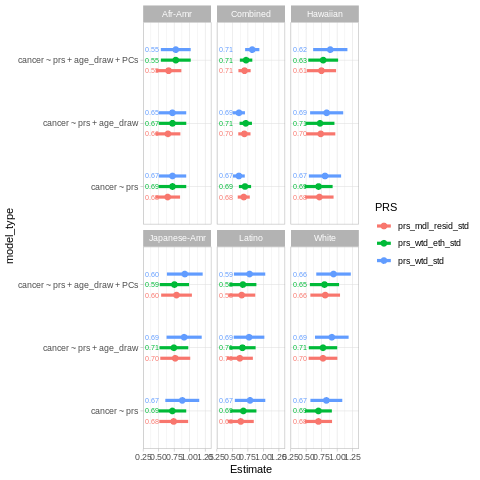

In [ ]:
%%R
all.fit.res %>%
  mutate(beta_lci = Estimate-(1.96*`Std. Error`),
         beta_uci = Estimate+(1.96*`Std. Error`)) %>%

  ggplot(aes(x=Estimate, y=model_type, color=PRS, xmin=beta_lci, xmax=beta_uci, label=sprintf("%.2f", auc)))+
  geom_point(position = position_dodge(width=.5), size=2.5) +
  geom_linerange(position = position_dodge(width=.5), linewidth = 1.5) +
  geom_text(position = position_dodge(width=.5), x=.4, size=2.5)+
  xlim(.3,1.3)+
  facet_wrap(~eth) +
  theme_light()